# In this notebook, we are going to build a 1D CNN for classification:

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt

## Tensorflow imports:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model

from verstack.stratified_continuous_split import scsplit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

## Load the Data:

In [2]:
very_light_data            = pd.read_csv("Data/inverted_OCR.csv")
very_light_data            = very_light_data.drop(columns = ['Index'])
#print(very_light_data.columns)
very_light_data.head()

,OTR,OCR,OMR,10_p_time_two_events,med_time_two_events,25_p_time_two_events,75_p_time_two_events,90_p_time_two_events,max_time_two_events,min_lifetime_cancel,med_lifetime_cancel,90_p_lifetime_cancel,NbTradeVenueMic,MaxNbTradesBySecond,MeanNbTradesBySecond,mean_dt_TV1,NbSecondWithAtLeatOneTrade,type,Nber_shares_same_day
0,0.440000,0.120000,0.080000,0.000000,419.688500,10.722543,984.320560,23151.83800,25139.598,682.153260,984.32056,23151.8380,1,7,2.750000,9639.216031,4,0,5
1,0.589404,0.039735,0.046358,0.000074,0.003374,0.000204,8.768699,2671.48830,31278.357,11.866026,177.93991,21433.6840,1,17,5.933333,493.559196,15,0,5
2,0.674419,0.021142,0.008457,0.000071,0.000599,0.000129,5.725427,448.88360,30799.467,2.761036,187.99548,1953.6235,1,20,5.063492,163.954785,63,0,4
3,0.586207,0.068966,0.034483,0.000000,6.152666,0.000945,62.444176,19187.71900,19187.719,286.019320,286.01932,19187.7190,1,8,4.250000,1232.562133,4,0,3
4,0.658879,0.037383,0.000000,0.000071,0.001364,0.000146,2.225420,273.45676,23164.514,2.798452,1345.95280,23164.5140,1,19,3.710526,248.073927,38,0,1


#### Splitting the data:

In [3]:
X_train, X_test, y_train, y_test = scsplit(very_light_data.drop(columns="type"), very_light_data['type'],
                                           stratify=very_light_data['type'],
                                           train_size=0.8, test_size=0.2,
                                            continuous = False) # tested

## Defining the model:

In [4]:
input_shape = (500, X_train.shape[1], 1)
x = tf.random.normal(input_shape)
layers.Conv1D(32, 5, activation='relu', input_shape=input_shape[1:])(x).shape

TensorShape([500, 14, 32])

In [5]:
y_train += 1
y_test  += 1

In [6]:
X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [7]:
cfg = {
    'lr': .001, #initial learning rate
    'optimizer': 'Adam', #type of optimizer, 'Adam', 'SGD', 'RMSprop'
    'batch_size': 500,
    'epochs': 60,
    'input_size': X_train.shape[1],
    'patience': 10,
    'scheduler_patience': 4,
    'scheduler_factor': 0.2
    }

model = tf.keras.Sequential([
    #layers.Conv1D(32, 3, activation='relu', input_shape=(cfg['input_size'], 1)),
    #layers.MaxPooling1D((2)),
    #layers.Conv1D(64, 3, activation='relu'),
    #layers.MaxPooling1D(2),    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(3)
    ])

optimizer = tf.keras.optimizers.RMSprop(cfg['lr'])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [8]:
# The patience parameter is number of epochs to check for improvement
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=cfg['scheduler_factor'],
                              patience=cfg['scheduler_patience'], min_lr=0.00001)

early_history = model.fit(X_train, y_train, 
                    epochs=cfg['epochs'], validation_split = 0.0, validation_data = (X_test, y_test), verbose=2, 
                    callbacks=[early_stop, reduce_lr], batch_size = 1000)

loss, acc = model.evaluate(X_test, y_test, verbose=2)

Epoch 1/60
85/85 - 1s - loss: 0.8234 - accuracy: 0.6286 - val_loss: 0.8264 - val_accuracy: 0.6773 - lr: 0.0010
Epoch 2/60
85/85 - 2s - loss: 0.6085 - accuracy: 0.7445 - val_loss: 0.6741 - val_accuracy: 0.7065 - lr: 0.0010
Epoch 3/60
85/85 - 1s - loss: 0.5562 - accuracy: 0.7674 - val_loss: 0.6016 - val_accuracy: 0.7317 - lr: 0.0010
Epoch 4/60
85/85 - 1s - loss: 0.5237 - accuracy: 0.7819 - val_loss: 0.5857 - val_accuracy: 0.7190 - lr: 0.0010
Epoch 5/60
85/85 - 1s - loss: 0.4954 - accuracy: 0.7942 - val_loss: 0.6245 - val_accuracy: 0.6986 - lr: 0.0010
Epoch 6/60
85/85 - 1s - loss: 0.4694 - accuracy: 0.8067 - val_loss: 0.5606 - val_accuracy: 0.7167 - lr: 0.0010
Epoch 7/60
85/85 - 1s - loss: 0.4411 - accuracy: 0.8206 - val_loss: 0.5186 - val_accuracy: 0.7645 - lr: 0.0010
Epoch 8/60
85/85 - 1s - loss: 0.4116 - accuracy: 0.8342 - val_loss: 0.4484 - val_accuracy: 0.8129 - lr: 0.0010
Epoch 9/60
85/85 - 1s - loss: 0.3866 - accuracy: 0.8450 - val_loss: 0.4321 - val_accuracy: 0.8235 - lr: 0.0010
E

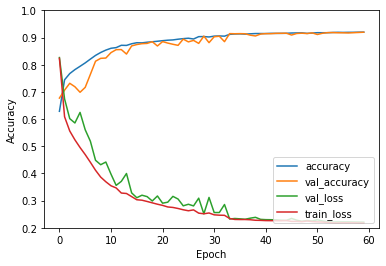

In [23]:
plt.plot(early_history.history['accuracy'], label='accuracy')
plt.plot(early_history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(early_history.history['val_loss'], label = 'val_loss')
plt.plot(early_history.history['loss'], label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  1216      
_________________________________________________________________
batch_normalization (BatchNo multiple                  256       
_________________________________________________________________
dense_1 (Dense)              multiple                  2080      
_________________________________________________________________
batch_normalization_1 (Batch multiple                  128       
_________________________________________________________________
dense_2 (Dense)              multiple                  528       
_________________________________________________________________
batch_normalization_2 (Batch multiple                  6

In [11]:
y_pred = model.predict(X_test).argmax(axis =1)

#### Confusion matrix:

In [12]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[9655,  241,  401],
       [ 230, 4141,   99],
       [ 629,  101, 5660]])

<AxesSubplot:>

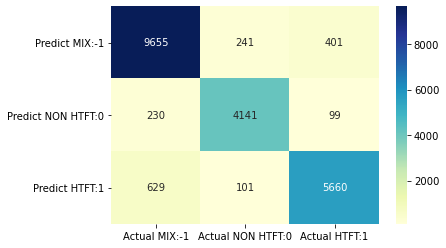

In [13]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual MIX:-1', 'Actual NON HTFT:0', 'Actual HTFT:1'], 
                                 index=['Predict MIX:-1', 'Predict NON HTFT:0', 'Predict HTFT:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [14]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93     10297
           1       0.92      0.93      0.93      4470
           2       0.92      0.89      0.90      6390

    accuracy                           0.92     21157
   macro avg       0.92      0.92      0.92     21157
weighted avg       0.92      0.92      0.92     21157



### Save model:

In [15]:
model.save("models/MLP_Batchnorm_2Hidden")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/MLP_Batchnorm_2Hidden/assets


In [16]:
#loaded_model = keras.models.load_model("models/MLP_Batchnorm_2Hidden")
#loaded_model.summary()

## With Dropout traders:

In [50]:
tf.keras.backend.clear_session()

cfg = {
    'lr': .001, #initial learning rate
    'optimizer': 'Adam', #type of optimizer, 'Adam', 'SGD', 'RMSprop'
    'batch_size': 1000,
    'epochs': 120,
    'input_size': X_train.shape[1],
    'patience': 10,
    'scheduler_patience': 4,
    'scheduler_factor': 0.2
    }


model = tf.keras.Sequential([
    #layers.Dense(18, activation='relu'),
    #layers.BatchNormalization(),    
#    layers.Conv1D(32, 3, activation='relu', input_shape=(cfg['input_size'], 1)),
#    layers.MaxPooling1D((2)),
#    layers.Conv1D(64, 3, activation='relu'),
#    layers.MaxPooling1D(2),    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.3),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.3),    
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.3),    
    #layers.Dense(8, activation='relu'),
    #layers.BatchNormalization(),
    #layers.Dropout(rate = 0.3),        
    layers.Dense(3)
    ])

optimizer = tf.keras.optimizers.RMSprop(cfg['lr'])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=cfg['patience'])

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=cfg['scheduler_factor'],
                              patience=4, min_lr=0.00001)

early_history2 = model.fit(X_train, y_train, #[:, [0,1,2,9,17,12,7,8,10,11]]
                    epochs=cfg['epochs'], validation_split = 0.0, validation_data = (X_test, y_test), verbose=2, 
                    callbacks=[early_stop, reduce_lr], batch_size = cfg['batch_size'])

Epoch 1/120
85/85 - 1s - loss: 1.1133 - accuracy: 0.5449 - val_loss: 0.8060 - val_accuracy: 0.6773 - lr: 0.0010
Epoch 2/120
85/85 - 1s - loss: 0.8579 - accuracy: 0.6196 - val_loss: 0.7191 - val_accuracy: 0.7068 - lr: 0.0010
Epoch 3/120
85/85 - 1s - loss: 0.7846 - accuracy: 0.6449 - val_loss: 0.6705 - val_accuracy: 0.7105 - lr: 0.0010
Epoch 4/120
85/85 - 1s - loss: 0.7406 - accuracy: 0.6622 - val_loss: 0.6518 - val_accuracy: 0.7158 - lr: 0.0010
Epoch 5/120
85/85 - 1s - loss: 0.7163 - accuracy: 0.6750 - val_loss: 0.6367 - val_accuracy: 0.7229 - lr: 0.0010
Epoch 6/120
85/85 - 1s - loss: 0.6879 - accuracy: 0.6909 - val_loss: 0.6196 - val_accuracy: 0.7277 - lr: 0.0010
Epoch 7/120
85/85 - 1s - loss: 0.6566 - accuracy: 0.7082 - val_loss: 0.6043 - val_accuracy: 0.7341 - lr: 0.0010
Epoch 8/120
85/85 - 1s - loss: 0.6331 - accuracy: 0.7244 - val_loss: 0.5745 - val_accuracy: 0.7542 - lr: 0.0010
Epoch 9/120
85/85 - 1s - loss: 0.6136 - accuracy: 0.7355 - val_loss: 0.5514 - val_accuracy: 0.7727 - lr:

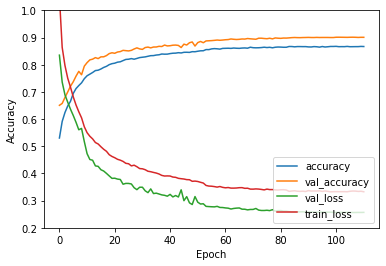

In [45]:
plt.plot(early_history2.history['accuracy'], label='accuracy')
plt.plot(early_history2.history['val_accuracy'], label = 'val_accuracy')
plt.plot(early_history2.history['val_loss'], label = 'val_loss')
plt.plot(early_history2.history['loss'], label = 'train_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')


In [46]:
y_pred2 = model.predict(X_test).argmax(axis =1)
y_pred2

array([0, 2, 0, ..., 2, 0, 0])

In [47]:
accuracy_score(y_pred2, y_test)

0.9008366025428935

#### Confusion matrix:

In [41]:
cm = confusion_matrix(y_test, y_pred2)
cm

array([[9515,  334,  448],
       [ 195, 4204,   71],
       [1082,  129, 5179]])

<AxesSubplot:>

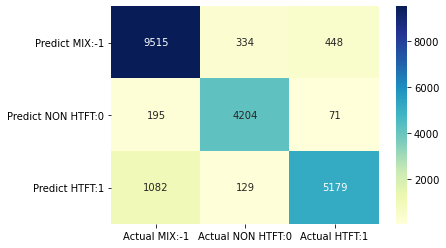

In [42]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual MIX:-1', 'Actual NON HTFT:0', 'Actual HTFT:1'], 
                                 index=['Predict MIX:-1', 'Predict NON HTFT:0', 'Predict HTFT:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [43]:
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

           0       0.88      0.92      0.90     10297
           1       0.90      0.94      0.92      4470
           2       0.91      0.81      0.86      6390

    accuracy                           0.89     21157
   macro avg       0.90      0.89      0.89     21157
weighted avg       0.89      0.89      0.89     21157



## Saving model

In [18]:
model.save("models/MLP_Batchnorm_dropout_2Hidden")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: models/MLP_Batchnorm_dropout_2Hidden/assets


## With Splitted traders:

In [11]:
X_train2, X_test2, y_train2, y_test2 = pd.read_pickle("Processed_data/X_train_evenly_splitted_traders.pkl"), pd.read_pickle("Processed_data/X_test_evenly_splitted_traders.pkl"), pd.read_pickle("Processed_data/y_train_evenly_splitted_traders.pkl"), pd.read_pickle("Processed_data/y_test_evenly_splitted_traders.pkl")

In [12]:
y_train2 += 1
y_test2  += 1

In [13]:
X_train2 = np.array(X_train2)
X_train2 = X_train2.reshape(X_train2.shape[0], X_train2.shape[1], 1)

X_test2 = np.array(X_test2)
X_test2 = X_test2.reshape(X_test2.shape[0], X_test2.shape[1], 1)

In [24]:
tf.keras.backend.clear_session()

cfg = {
    'lr': .001, #initial learning rate
    'optimizer': 'Adam', #type of optimizer, 'Adam', 'SGD', 'RMSprop'
    'batch_size': 500,
    'epochs': 60,
    'input_size': X_train.shape[1],
    'patience': 10,
    'scheduler_patience': 4,
    'scheduler_factor': 0.2
    }


model = tf.keras.Sequential([
    #layers.Dense(18, activation='relu'),
    #layers.BatchNormalization(),    
#    layers.Conv1D(32, 3, activation='relu', input_shape=(cfg['input_size'], 1)),
#    layers.MaxPooling1D((2)),
#    layers.Conv1D(64, 3, activation='relu'),
#    layers.MaxPooling1D(2),    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.3),
    layers.Dense(32, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.3),    
    layers.Dense(16, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(rate = 0.3),    
    layers.Dense(3)
    ])

optimizer = tf.keras.optimizers.RMSprop(cfg['lr'])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=4, min_lr=0.00001)

early_history2 = model.fit(X_train2, y_train2, 
                    epochs=cfg['epochs'], validation_split = 0.0, validation_data = (X_test2, y_test2), verbose=2, 
                    callbacks=[early_stop, reduce_lr], batch_size = 1000)

Epoch 1/60
84/84 - 1s - loss: 1.0549 - accuracy: 0.5342 - val_loss: 1.9998 - val_accuracy: 0.4158 - lr: 0.0010
Epoch 2/60
84/84 - 1s - loss: 0.8283 - accuracy: 0.6240 - val_loss: 1.5377 - val_accuracy: 0.4415 - lr: 0.0010
Epoch 3/60
84/84 - 1s - loss: 0.7465 - accuracy: 0.6632 - val_loss: 1.4040 - val_accuracy: 0.4478 - lr: 0.0010
Epoch 4/60
84/84 - 1s - loss: 0.6970 - accuracy: 0.6952 - val_loss: 1.3814 - val_accuracy: 0.4577 - lr: 0.0010
Epoch 5/60
84/84 - 1s - loss: 0.6591 - accuracy: 0.7202 - val_loss: 1.3232 - val_accuracy: 0.4767 - lr: 0.0010
Epoch 6/60
84/84 - 1s - loss: 0.6283 - accuracy: 0.7389 - val_loss: 1.2963 - val_accuracy: 0.4924 - lr: 0.0010
Epoch 7/60
84/84 - 1s - loss: 0.5895 - accuracy: 0.7624 - val_loss: 1.3087 - val_accuracy: 0.4815 - lr: 0.0010
Epoch 8/60
84/84 - 1s - loss: 0.5573 - accuracy: 0.7783 - val_loss: 1.4231 - val_accuracy: 0.4782 - lr: 0.0010
Epoch 9/60
84/84 - 1s - loss: 0.5313 - accuracy: 0.7930 - val_loss: 1.3985 - val_accuracy: 0.4724 - lr: 0.0010
E

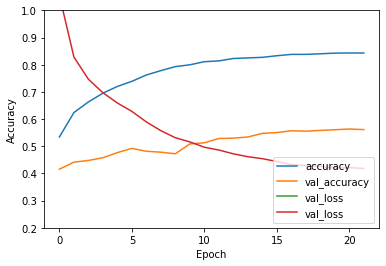

In [25]:
plt.plot(early_history2.history['accuracy'], label='accuracy')
plt.plot(early_history2.history['val_accuracy'], label = 'val_accuracy')
plt.plot(early_history2.history['val_loss'], label = 'val_loss')
plt.plot(early_history2.history['loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.2, 1])
plt.legend(loc='lower right')


In [19]:
y_pred2 = model.predict(X_test2).argmax(axis =1)
y_pred2

array([0, 0, 2, ..., 0, 0, 0])

In [20]:
accuracy_score(y_pred2, y_test2)

0.4931543149898419

#### Confusion matrix:

In [21]:
cm = confusion_matrix(y_test2, y_pred2)
cm

array([[4768, 5653,  449],
       [ 433, 4864,  339],
       [4556,   46, 1534]])

<AxesSubplot:>

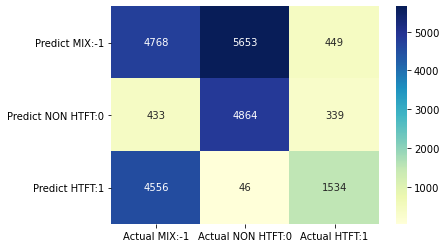

In [22]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual MIX:-1', 'Actual NON HTFT:0', 'Actual HTFT:1'], 
                                 index=['Predict MIX:-1', 'Predict NON HTFT:0', 'Predict HTFT:1'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [23]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.49      0.44      0.46     10870
           1       0.46      0.86      0.60      5636
           2       0.66      0.25      0.36      6136

    accuracy                           0.49     22642
   macro avg       0.54      0.52      0.48     22642
weighted avg       0.53      0.49      0.47     22642

